# Model Test Results by Epoch

In [68]:
# Module used to connect Python with MongoDB
from pymongo import MongoClient
from datetime import datetime
import json
import pandas as pd
from pprint import pprint
import os
import csv
import re

In [69]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [70]:
# confirm that our new database was created
print(mongo.list_database_names())

['admin', 'autosaurus', 'classDB', 'config', 'epa', 'fruits_db', 'local', 'met', 'petsitly_marketing', 'sofia_test_model', 'uk_food']


In [71]:
# assign the database to a variable name
db = mongo['sofia_test_model']

In [72]:
# assign the collection to a variable
epoch_test_results = db['epoch_test_results']

In [73]:
# Step 2: Read and modify JSON data

json_dir = 'Resources_MongoDB'

# Prompt the user to enter the filename they want to import
file_to_import = input("Enter the filename you want to import (e.g., file1.json): ")


all_data = []
for file_name in os.listdir(json_dir):

    if file_name == file_to_import:

        if file_name.endswith('.json'):

            match = re.search(r'(\d{8})_(\d{6})', file_name)  # Extract date and timestamp using regex expression

            if match:
                date_str, time_str = match.groups()

                try:
                    # Convert the datetime object to a formatted string
                    date_str_format = f"{date_str}_{time_str}"

                    with open(os.path.join(json_dir, file_name), 'r') as file:
                        json_data = json.load(file)

                    version_number = 1  # Define the version number

                    # Create a dictionary to hold epoch results
                    epoch_results = {}

                    for item in json_data:
                        # Check if 'epoch', 'accuracy', and 'loss' keys exist in the item dictionary
                        if 'epoch' in item and 'accuracy' in item and 'loss' in item:
                            epoch_value = item['epoch']
                            accuracy_value = float(item['accuracy'])  # Convert accuracy to float
                            loss_value = float(item['loss'])  # Convert loss to float

                            epoch_results[epoch_value] = {
                                'accuracy': accuracy_value,
                                'loss': loss_value
                            }

                    formatted_data = {
                        "version": version_number,
                        "date": date_str_format,
                        "epoch": epoch_results
                    }

                    all_data.append(formatted_data)
                except ValueError:
                    print(f"Warning: File name {file_name} does not contain a valid date and timestamp in the format 'YYYYMMDD_HHMMSS'. Skipping...")
                    continue
        else:
            print("Error: Invalid file format. Only JSON files are allowed.")

# Step 3: Insert the modified JSON data into MongoDB
epoch_test_results.insert_many(all_data)

print("Data imported successfully into MongoDB.")

Data imported successfully into MongoDB.


In [74]:

print(db.list_collection_names())

for document in epoch_test_results.find():
    print(document)


#db.epoch_test_results.drop()


['epoch_test_results', 'loss_accuracy', 'confusion_matrix', 'processed_data']
{'_id': ObjectId('64d20d1a754835300875be33'), 'version': 1, 'date': '20230806_100824', 'epoch': {'5': {'accuracy': 0.8198198080062866, 'loss': 0.6587201952934265}, '10': {'accuracy': 0.8018018007278442, 'loss': 0.6192963123321533}, '15': {'accuracy': 0.8018018007278442, 'loss': 0.583991527557373}, '20': {'accuracy': 0.8018018007278442, 'loss': 0.5513034462928772}, '25': {'accuracy': 0.8018018007278442, 'loss': 0.5240681171417236}, '30': {'accuracy': 0.8018018007278442, 'loss': 0.5032863616943359}, '35': {'accuracy': 0.8018018007278442, 'loss': 0.4848848581314087}, '40': {'accuracy': 0.8018018007278442, 'loss': 0.47161656618118286}, '45': {'accuracy': 0.8108108043670654, 'loss': 0.4609447121620178}, '50': {'accuracy': 0.8198198080062866, 'loss': 0.45186224579811096}, '55': {'accuracy': 0.8198198080062866, 'loss': 0.4415457844734192}, '60': {'accuracy': 0.8198198080062866, 'loss': 0.4307141602039337}, '65': {'a

In [75]:

# Step 2: Check the result
print(f"Deleted {epoch_test_results.deleted_count} records with empty 'epoch' dictionary.")

for document in epoch_test_results.find():
    pprint(document)

Deleted Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sofia_test_model'), 'epoch_test_results.deleted_count') records with empty 'epoch' dictionary.
{'_id': ObjectId('64d20d1a754835300875be33'),
 'date': '20230806_100824',
 'epoch': {'10': {'accuracy': 0.8018018007278442, 'loss': 0.6192963123321533},
           '100': {'accuracy': 0.8648648858070374, 'loss': 0.3702228367328644},
           '15': {'accuracy': 0.8018018007278442, 'loss': 0.583991527557373},
           '20': {'accuracy': 0.8018018007278442, 'loss': 0.5513034462928772},
           '25': {'accuracy': 0.8018018007278442, 'loss': 0.5240681171417236},
           '30': {'accuracy': 0.8018018007278442, 'loss': 0.5032863616943359},
           '35': {'accuracy': 0.8018018007278442, 'loss': 0.4848848581314087},
           '40': {'accuracy': 0.8018018007278442, 'loss': 0.47161656618118286},
           '45': {'accuracy': 0.8108108043670654, 'loss': 0.4609447121620178},


In [76]:
data = []
for document in epoch_test_results.find():
    data.append(document)

df = pd.DataFrame(data)
df.rename(columns={'_id': 'ID', 'version':'Version','date':'Date'}, inplace=True)

df.head()

,ID,Version,Date,epoch
0,64d20d1a754835300875be33,1,20230806_100824,"{'5': {'accuracy': 0.8198198080062866, 'loss':..."


In [77]:
epoch_accuracy_data = []
for document in epoch_test_results.find():
    if 'epoch' in document:
        epoch = max(document['epoch'], key=lambda x: document['epoch'][x]['accuracy'])
        accuracy = document['epoch'][epoch]['accuracy']
        epoch_accuracy_data.append({'epoch': epoch, 'accuracy': accuracy})

# Create a Pandas DataFrame from the extracted data
df = pd.DataFrame(epoch_accuracy_data)

# Display the DataFrame
df.head()

,epoch,accuracy
0,100,0.864865


In [78]:
epoch_data = []
for document in epoch_test_results.find():
    if 'epoch' in document:
        epoch_data.append(document['epoch'])

# Create a Pandas DataFrame from the extracted "epoch" values
df = pd.DataFrame(epoch_data)

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Create a new DataFrame with the "epoch" keys as separate columns
new_columns = pd.concat([df['10'], df['100'], df['15'], df['20'], df['25'], df['30'],
                         df['35'], df['40'], df['45'], df['5'], df['50'], df['55'],
                         df['60'], df['65'], df['70'], df['75'], df['80'], df['85'],
                         df['90'], df['95']], axis=1)

# Display the new DataFrame with separate columns for each "epoch" key
print("\nDataFrame with Separate Epoch Columns:")

accuracy_df = df.applymap(lambda x: x['accuracy'])
loss_df = df.applymap(lambda x: x['loss'])

# Display the accuracy and loss DataFrames
print("Accuracy DataFrame:")
print(accuracy_df)

print("\nLoss DataFrame:")
print(loss_df)

accuracy_df

Original DataFrame:
                                                   5  \
0  {'accuracy': 0.8198198080062866, 'loss': 0.658...   

                                                  10  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.619...   

                                                  15  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.583...   

                                                  20  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.551...   

                                                  25  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.524...   

                                                  30  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.503...   

                                                  35  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.484...   

                                                  40  \
0  {'accuracy': 0.8018018007278442, 'loss': 0.471...   

                                                  45  \
0  {'accuracy': 0.81

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
0,0.81982,0.801802,0.801802,0.801802,0.801802,0.801802,0.801802,0.801802,0.810811,0.81982,0.81982,0.81982,0.81982,0.828829,0.837838,0.855856,0.855856,0.855856,0.855856,0.864865


Text(0, 0.5, 'Accuracy')

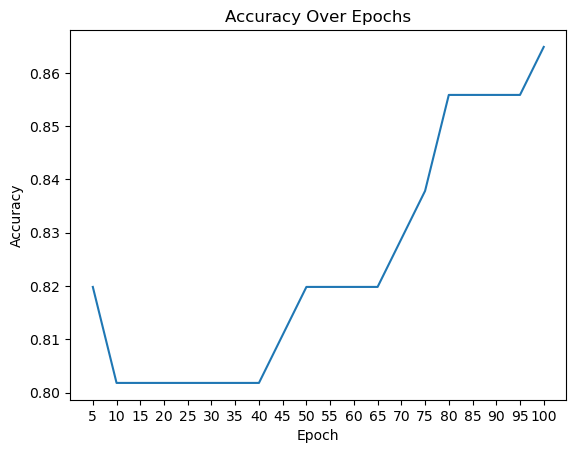

In [79]:
from matplotlib import pyplot as plt


columns = accuracy_df.columns.tolist()
values = accuracy_df.iloc[0].tolist()
plt.plot(columns, values)
plt.title('Accuracy Over Epochs')  # Add a title to the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [80]:

# Sample data
columns = accuracy_df.columns.tolist()
values = accuracy_df.iloc[0].tolist()

# Create a vertical table DataFrame
accuracy_table = pd.DataFrame({'Epoch': columns, 'Accuracy': values})

# Display the vertical table DataFrame
df_accuracy_table=accuracy_table

df_accuracy_table.head(20)

,Epoch,Accuracy
0,5,0.819820
1,10,0.801802
2,15,0.801802
3,20,0.801802
4,25,0.801802
5,30,0.801802
6,35,0.801802
7,40,0.801802
8,45,0.810811
9,50,0.819820


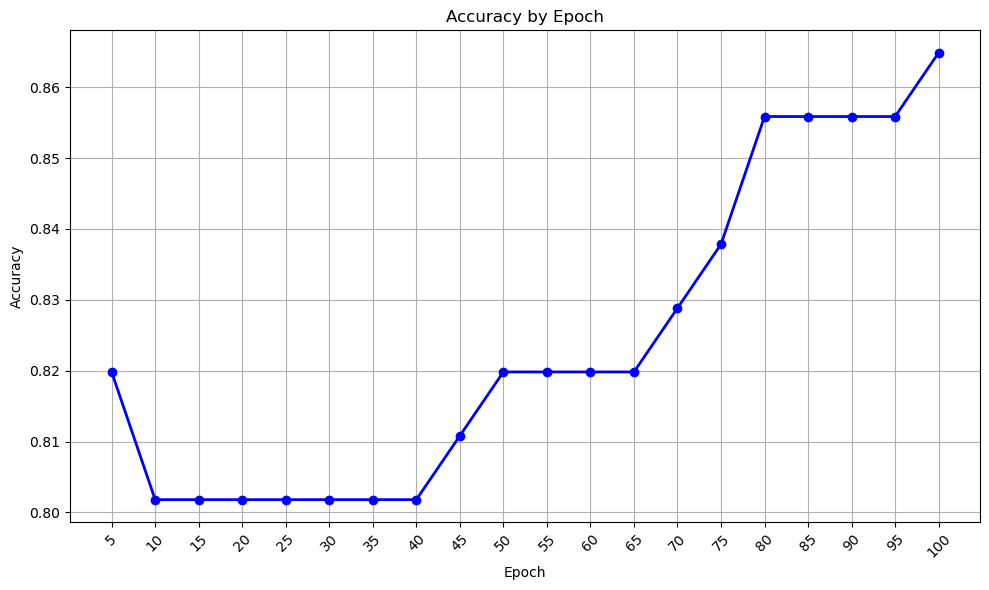

In [81]:
# Plot the data as a line chart
plt.figure(figsize=(10, 6))
plt.plot(accuracy_table['Epoch'], accuracy_table['Accuracy'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Loss')

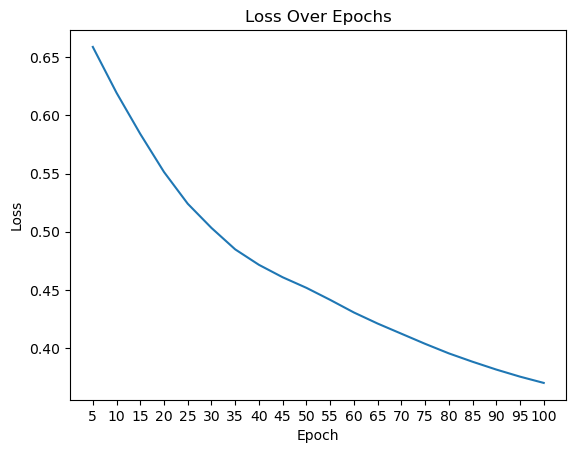

In [82]:
columns = loss_df.columns.tolist()
values = loss_df.iloc[0].tolist()
plt.plot(columns, values)
plt.title('Loss Over Epochs')  # Add a title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [83]:
# Sample data
columns = loss_df.columns.tolist()
values = loss_df.iloc[0].tolist()

# Create a vertical table DataFrame
loss_table = pd.DataFrame({'Epoch': columns, 'Loss': values})

df_loss_table=loss_table

df_loss_table

,Epoch,Loss
0,5,0.658720
1,10,0.619296
2,15,0.583992
3,20,0.551303
4,25,0.524068
5,30,0.503286
6,35,0.484885
7,40,0.471617
8,45,0.460945
9,50,0.451862


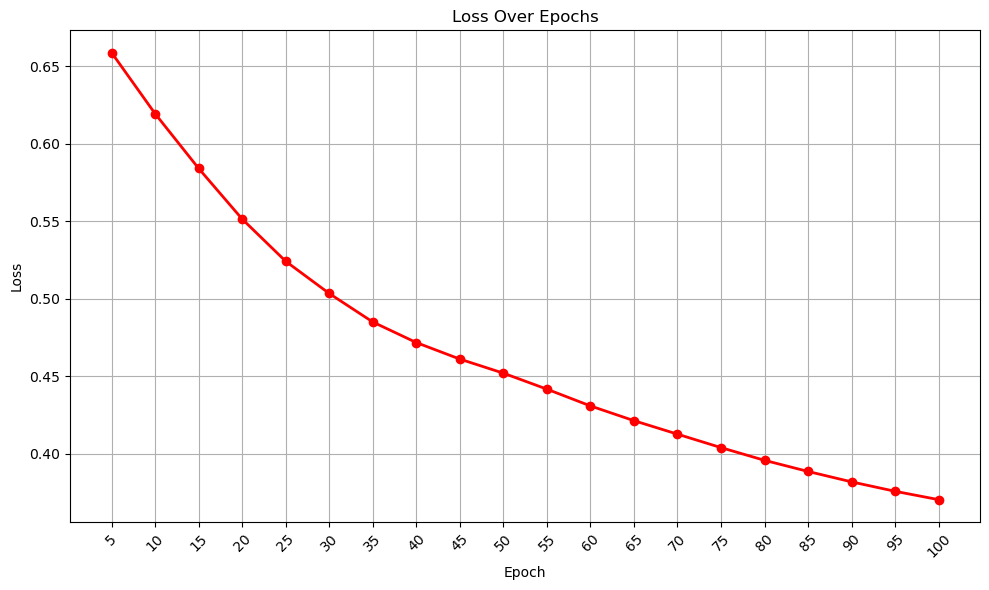

In [84]:
# Plot the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(loss_table['Epoch'], loss_table['Loss'], marker='o', color='red', linestyle='-', linewidth=2)
plt.title('Loss Over Epochs')  # Add a title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

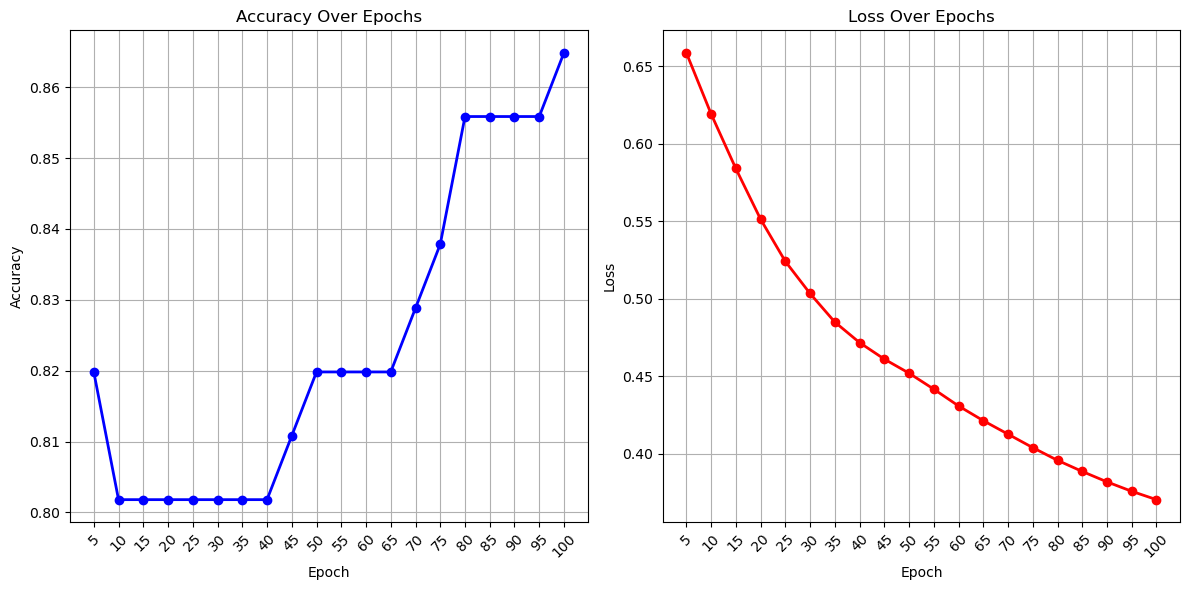

In [85]:
# Sample data for accuracy and loss
accuracy_columns = accuracy_df.columns.tolist()
accuracy_values = accuracy_df.iloc[0].tolist()

loss_columns = loss_df.columns.tolist()
loss_values = loss_df.iloc[0].tolist()

# Create vertical table DataFrames
accuracy_table = pd.DataFrame({'Epoch': accuracy_columns, 'Accuracy': accuracy_values})
loss_table = pd.DataFrame({'Epoch': loss_columns, 'Loss': loss_values})

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(accuracy_table['Epoch'], accuracy_table['Accuracy'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(loss_table['Epoch'], loss_table['Loss'], marker='o', color='red', linestyle='-', linewidth=2)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('Accuracy_and_Loss_Over_Epochs_SamePlot.png')


plt.show()

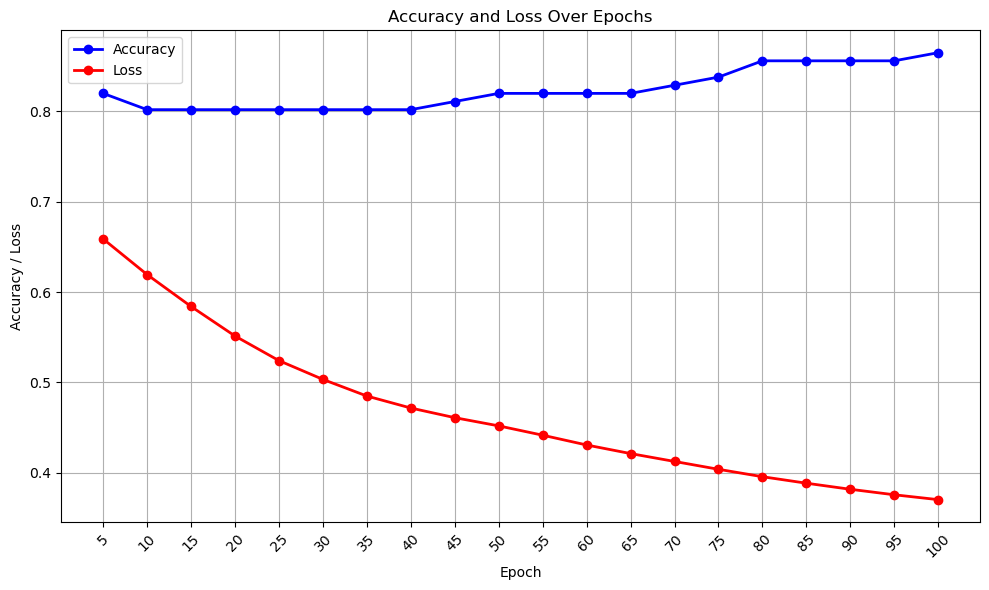

In [86]:
# Sample data for accuracy and loss
accuracy_columns = accuracy_df.columns.tolist()
accuracy_values = accuracy_df.iloc[0].tolist()

loss_columns = loss_df.columns.tolist()
loss_values = loss_df.iloc[0].tolist()

# Create vertical table DataFrames
accuracy_table = pd.DataFrame({'Epoch': accuracy_columns, 'Accuracy': accuracy_values})
loss_table = pd.DataFrame({'Epoch': loss_columns, 'Loss': loss_values})

# Plot both line charts on the same plot
plt.figure(figsize=(10, 6))

plt.plot(accuracy_table['Epoch'], accuracy_table['Accuracy'], marker='o', color='blue', linestyle='-', linewidth=2, label='Accuracy')
plt.plot(loss_table['Epoch'], loss_table['Loss'], marker='o', color='red', linestyle='-', linewidth=2, label='Loss')

plt.title('Accuracy and Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()

plt.savefig('Accuracy_and_Loss_Over_Epochs.png')

plt.show()

In [87]:
accuracy_table.to_csv('accuracy_output.csv', index=False)
loss_table.to_csv('loss_output.csv', index=False)

In [88]:
db.epoch_test_results.drop()